In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam # is running better on M3 chip
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.image as mpimg
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

#set the seed for reproducibility
seed = 55
# base 
base = "better-mura/MURA-v1.1/"

In [3]:
def get_data(df):
    data = []

    # only loading wrist images
    for index, row in df.iterrows():
        # wrist images
        if "XR_WRIST" in row['path']:
            image_path = os.path.join(base, row['path'])
            label = 1 if "positive" in row['path'] else 0

            if os.path.exists(image_path):
                data.append((image_path, label))
            else:
                print(f"Image not found: {image_path}")
    return data


Total images: 224045
Total wrist images: 59171


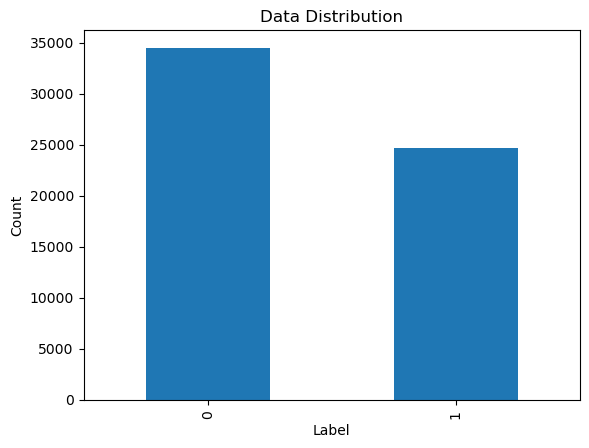

In [4]:
# Merging CSV files
df1 = pd.read_csv(f"{base}/MURA-v1.1/train_augmented.csv")
df2 = pd.read_csv(f"{base}/MURA-v1.1/valid.csv")

# Merge DataFrames and drop NaN values
df = pd.concat([df1, df2], ignore_index=True).dropna()
print(f"Total images: {len(df)}")

# get data
data = get_data(df)
print(f"Total wrist images: {len(data)}")
data = pd.DataFrame(data, columns=["path", "label"])
data.head()
# data distribution
data['label'].value_counts().plot(kind='bar')
plt.title('Data Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

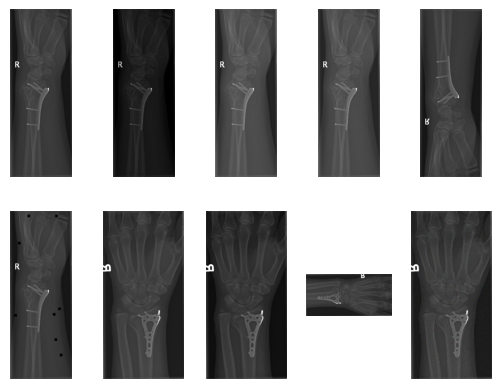

In [5]:
# show the first 10 images
for i in range(10):
    img = mpimg.imread(data['path'][i])
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [6]:
# split all dataset 10% test and 90% train and validation
# stratified splitting
train_df, test_df = train_test_split(data, test_size=0.1, stratify=data['label'], random_state=seed)
print(f"Train images: {len(train_df)}")
print(f"Test images: {len(test_df)}")

Train images: 53253
Test images: 5918


In [7]:
# Define image data generator with augmentation
generator = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    brightness_range=(0.5, 1.5),
    validation_split=0.2  # Splitting within the generator itself
)

# Common parameters for train and validation generators
common_params = {
    "dataframe": train_df,
    "x_col": "path",
    "y_col": "label",
    "target_size": (224, 224),
    "color_mode": "rgb",
    "class_mode": "raw",
    "batch_size": 64,
    "shuffle": True,
    "seed": seed,
}

# Create=ing train and validation generators
train_images = generator.flow_from_dataframe(**common_params, subset="training")
val_images = generator.flow_from_dataframe(**common_params, subset="validation")

# Test generator (no data augmentation, no shuffling)
test_images = ImageDataGenerator().flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="label",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="raw",
    batch_size=32,
    shuffle=False
)


Found 42603 validated image filenames.
Found 10650 validated image filenames.
Found 5918 validated image filenames.


In [ ]:
# Load pre-trained ResNet50 model
pretrained_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze most layers for feature extraction
for layer in pretrained_model.layers[:-10]:
    layer.trainable = False

# Build model
x = pretrained_model.output  # Feature vector output from ResNet50
x = Dense(12, activation='relu')(x)  # Fully connected layer
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification output

model = tf.keras.Model(inputs=pretrained_model.input, outputs=outputs)

# Defining class weights to handle class imbalance
class_weights = {0: 1.0, 1: 1.5}  # Increase weight for fractures

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
callbacks = [EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]

# Train the model with class weights
history = model.fit(train_images, validation_data=val_images, epochs=10, callbacks=callbacks, class_weight=class_weights)



############## efficientnet
# Load pre-trained EfficientNetB0 model
pretrained_model_eff = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
# Freeze most layers for feature extraction
for layer in pretrained_model_eff.layers[:-10]:
    layer.trainable = False
# Build model
x = pretrained_model_eff.output  # Feature vector output from EfficientNetB0
x = Dense(12, activation='relu')(x)  # Fully connected layer
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification output
model_eff = tf.keras.Model(inputs=pretrained_model_eff.input, outputs=outputs)
# Compile the model
model_eff.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# Train the model with class weights
history_eff = model_eff.fit(train_images, validation_data=val_images, epochs=10, callbacks=callbacks, class_weight=class_weights)
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
# Evaluate the model on the test set
test_loss_eff, test_accuracy_eff = model_eff.evaluate(test_images)
print(f"Test Loss: {test_loss_eff:.4f}")
print(f"Test Accuracy: {test_accuracy_eff:.4f}")


Epoch 1/10


2025-04-09 23:41:26.052893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-04-09 23:41:26.058983: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


666/666 [==============================] - ETA: 0s - loss: 0.5590 - accuracy: 0.7753

2025-04-10 00:09:26.243208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


666/666 [==============================] - 2061s 3s/step - loss: 0.5590 - accuracy: 0.7753 - val_loss: 0.4117 - val_accuracy: 0.8126
Epoch 2/10
666/666 [==============================] - 2237s 3s/step - loss: 0.4632 - accuracy: 0.8286 - val_loss: 0.3626 - val_accuracy: 0.8374
Epoch 3/10
666/666 [==============================] - 2359s 4s/step - loss: 0.4141 - accuracy: 0.8489 - val_loss: 0.3327 - val_accuracy: 0.8534
Epoch 4/10
666/666 [==============================] - 2489s 4s/step - loss: 0.3662 - accuracy: 0.8698 - val_loss: 0.3348 - val_accuracy: 0.8504
Epoch 5/10
666/666 [==============================] - 2522s 4s/step - loss: 0.3332 - accuracy: 0.8815 - val_loss: 0.3308 - val_accuracy: 0.8512
Epoch 6/10
666/666 [==============================] - 2337s 4s/step - loss: 0.2983 - accuracy: 0.8965 - val_loss: 0.2945 - val_accuracy: 0.8766
Epoch 7/10
666/666 [==============================] - 2337s 4s/step - loss: 0.2629 - accuracy: 0.9108 - val_loss: 0.2751 - val_accuracy: 0.8859
Epo

2025-04-10 06:10:54.673681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


666/666 [==============================] - ETA: 0s - loss: 0.5914 - accuracy: 0.7549

2025-04-10 06:22:13.520074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


666/666 [==============================] - 840s 1s/step - loss: 0.5914 - accuracy: 0.7549 - val_loss: 0.4459 - val_accuracy: 0.7882
Epoch 2/10
666/666 [==============================] - 840s 1s/step - loss: 0.5088 - accuracy: 0.8062 - val_loss: 0.4084 - val_accuracy: 0.8097
Epoch 3/10
666/666 [==============================] - 844s 1s/step - loss: 0.4803 - accuracy: 0.8185 - val_loss: 0.3912 - val_accuracy: 0.8227
Epoch 4/10
666/666 [==============================] - 836s 1s/step - loss: 0.4582 - accuracy: 0.8307 - val_loss: 0.3674 - val_accuracy: 0.8390
Epoch 5/10
666/666 [==============================] - 787s 1s/step - loss: 0.4328 - accuracy: 0.8407 - val_loss: 0.3587 - val_accuracy: 0.8423
Epoch 6/10
666/666 [==============================] - 768s 1s/step - loss: 0.4204 - accuracy: 0.8441 - val_loss: 0.3391 - val_accuracy: 0.8567
Epoch 7/10
666/666 [==============================] - 833s 1s/step - loss: 0.4021 - accuracy: 0.8542 - val_loss: 0.3623 - val_accuracy: 0.8297
Epoch 8/10

2025-04-10 08:30:11.330404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


185/185 [==============================] - 185s 1s/step - loss: 0.2841 - accuracy: 0.8907
Test Loss: 0.2841
Test Accuracy: 0.8907


2025-04-10 08:33:16.659538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


185/185 [==============================] - 66s 359ms/step - loss: 0.3095 - accuracy: 0.8625
Test Loss: 0.3095
Test Accuracy: 0.8625


2025-04-10 08:34:23.089807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


185/185 [==============================] - 182s 982ms/step


2025-04-10 08:37:25.248606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


185/185 [==============================] - 68s 364ms/step


AttributeError: 'DataFrameIterator' object has no attribute 'classes'

2025-04-10 16:15:24.033434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


185/185 [==============================] - 142s 768ms/step
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      3451
           1       0.92      0.82      0.87      2467

    accuracy                           0.89      5918
   macro avg       0.90      0.88      0.89      5918
weighted avg       0.90      0.89      0.89      5918

ROC AUC Score: 0.956576975450035


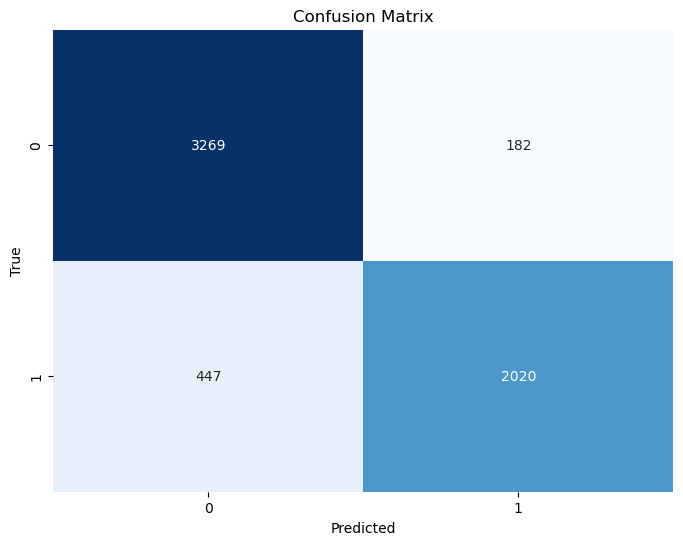

better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient01761/study1_positive/image1_aug_2_RandomResizedCrop.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient06609/study1_positive/image2_aug_3_Cutout.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient03787/study1_negative/image2_aug_3_RandomBrightnessContrast.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient08068/study1_negative/image2.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient08189/study1_negative/image3.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient08386/study1_negative/image1_aug_3_RandomBrightness.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient07383/study1_positive/image1_aug_1_GaussNoise.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient06687/study1_positive/image2_aug_1_RandomBrightness.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient06370/study1_positive/image1_

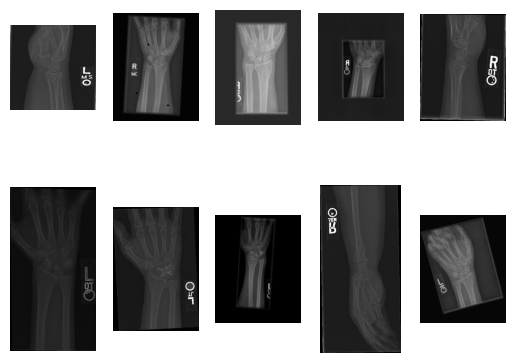

better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient07690/study1_negative/image1_aug_3_RandomBrightness.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient06380/study1_positive/image2_aug_5_RandomResizedCrop.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient03076/study1_positive/image1_aug_2_RandomBrightness.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient08593/study1_negative/image3_aug_4_GaussNoise.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient08365/study1_negative/image3_aug_2_GaussNoise.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient01693/study1_positive/image3_aug_1_Blur.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient06853/study1_positive/image3_aug_3_Blur.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient08441/study1_positive/image3_aug_4_GaussNoise.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient06611/study1_posi

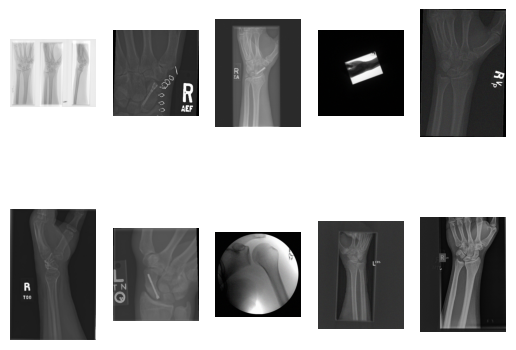

In [ ]:
# Predict on test data
y_pred_prob = model.predict(test_images)
y_pred = (y_pred_prob > 0.4).astype(int)  # Lower threshold to improve recall

# Extract true labels
true_labels = test_images.labels  

# Print classification report
print(classification_report(true_labels, y_pred))

# Calculate ROC AUC score
roc_auc = roc_auc_score(true_labels, y_pred_prob)
print(f"ROC AUC Score: {roc_auc}")

# Confusion matrix

cm = confusion_matrix(true_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()



In [ ]:
results = model.evaluate(test_images, verbose=0)
print(" Results:")
print(results)
acc=np.round(results[1] * 100, 2)
print(f"Test Accuracy: {acc}%")
model.save(f"{acc}.h5")


2025-03-23 23:31:41.786723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 Results:
[0.24105054140090942, 0.9028388261795044]
Test Accuracy: 90.28%


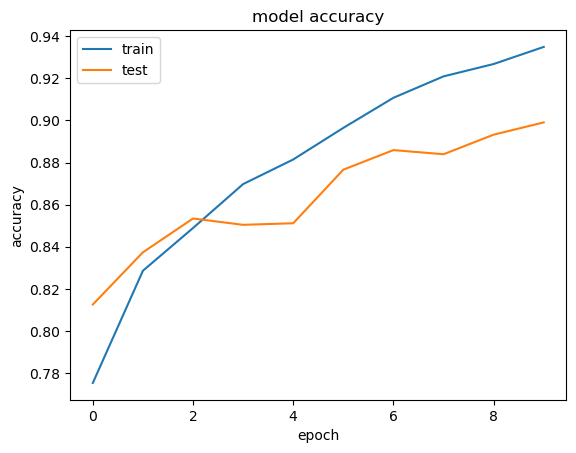

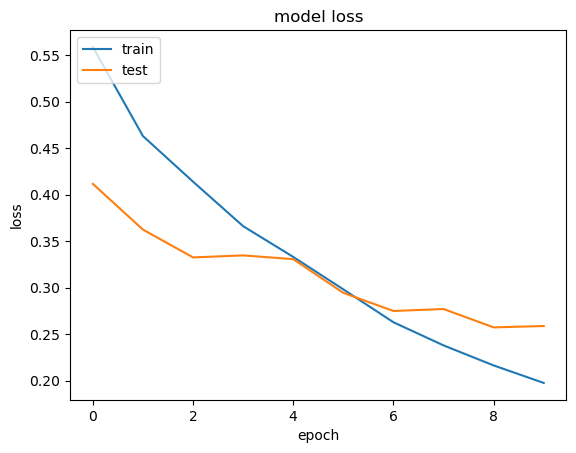

Model saved as model.h5
Done


In [12]:

# create plots for accuracy and save it
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# create plots for loss and save it
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# save the model
model.save("model.h5")
print("Model saved as model.h5")
print("Done")




2025-04-10 16:24:05.947589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


185/185 [==============================] - 50s 268ms/step
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      3451
           1       0.86      0.80      0.83      2467

    accuracy                           0.86      5918
   macro avg       0.86      0.85      0.86      5918
weighted avg       0.86      0.86      0.86      5918

ROC AUC Score: 0.9367192581014626


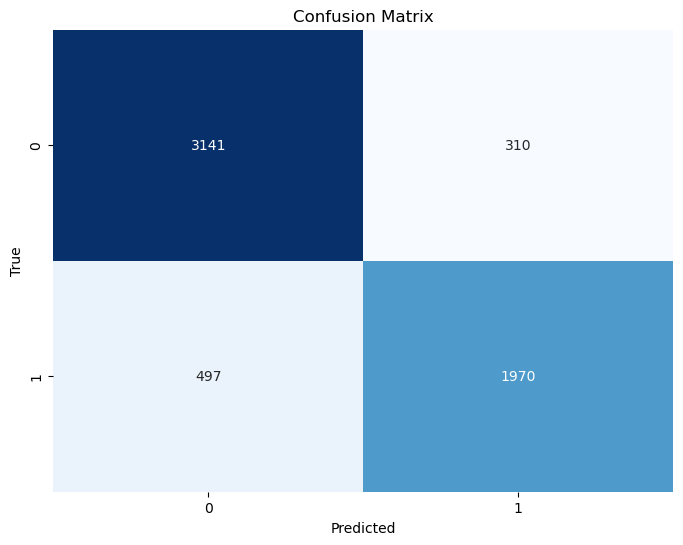

In [13]:
#efficientnet
# Predict on test data
y_pred_prob_eff = model_eff.predict(test_images)
y_pred_eff = (y_pred_prob_eff > 0.4).astype(int)  # Lower threshold to improve recall
# Extract true labels
true_labels_eff = test_images.labels
# Print classification report
print(classification_report(true_labels_eff, y_pred_eff))
# Calculate ROC AUC score
roc_auc_eff = roc_auc_score(true_labels_eff, y_pred_prob_eff)
print(f"ROC AUC Score: {roc_auc_eff}")
# Confusion matrix
cm_eff = confusion_matrix(true_labels_eff, y_pred_eff)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_eff, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


              precision    recall  f1-score   support

           0       0.90      0.95      0.92      3451
           1       0.92      0.85      0.89      2467

    accuracy                           0.91      5918
   macro avg       0.91      0.90      0.90      5918
weighted avg       0.91      0.91      0.91      5918

ROC AUC Score: 0.9640303292948227


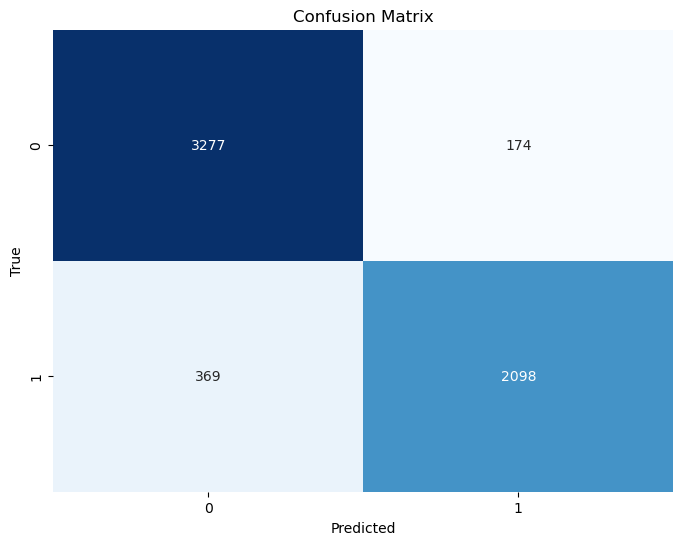

In [18]:
#ensemble # Predict on test data
y_pred_prob_ensemble = (y_pred_prob + y_pred_prob_eff) / 2
y_pred_ensemble = (y_pred_prob_ensemble > 0.4).astype(int)  # Lower threshold to improve recall
# Extract true labels
true_labels_ensemble = test_images.labels
# Print classification report
print(classification_report(true_labels_ensemble, y_pred_ensemble))
# Calculate ROC AUC score
roc_auc_ensemble = roc_auc_score(true_labels_ensemble, y_pred_prob_ensemble)
print(f"ROC AUC Score: {roc_auc_ensemble}")
# Confusion matrix
cm_ensemble = confusion_matrix(true_labels_ensemble, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



            Model  Test Loss  Test Accuracy  ROC AUC Score
0        ResNet50   0.284117       0.890673       0.956577
1  EfficientNetB0   0.309452       0.862454       0.936719
2        Ensemble        NaN            NaN       0.964030


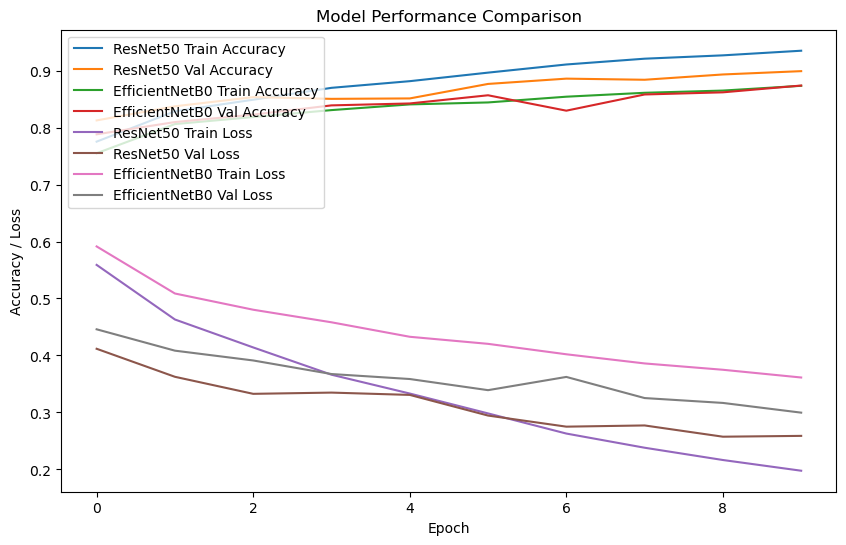

In [ ]:
#comparing the models
# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'Model': ['ResNet50', 'EfficientNetB0', 'Ensemble'],
    'Test Loss': [test_loss, test_loss_eff, None],
    'Test Accuracy': [test_accuracy, test_accuracy_eff, None],
    'ROC AUC Score': [roc_auc, roc_auc_eff, roc_auc_ensemble]
})
# Save the results to a CSV file
results_df.to_csv('model_comparison.csv', index=False)
# Print the DataFrame
print(results_df)
# Save the ensemble model
# plot All the results on one graph
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='ResNet50 Train Accuracy')
plt.plot(history.history['val_accuracy'], label='ResNet50 Val Accuracy')
plt.plot(history_eff.history['accuracy'], label='EfficientNetB0 Train Accuracy')
plt.plot(history_eff.history['val_accuracy'], label='EfficientNetB0 Val Accuracy')
plt.plot(history.history['loss'], label='ResNet50 Train Loss')
plt.plot(history.history['val_loss'], label='ResNet50 Val Loss')
plt.plot(history_eff.history['loss'], label='EfficientNetB0 Train Loss')
plt.plot(history_eff.history['val_loss'], label='EfficientNetB0 Val Loss')
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy / Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
# Save the ensemble model


In [20]:
#TODO GRADCAM

# Grad-CAM
def grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # Assuming binary classification
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()
# Load an image for Grad-CAM

img_path = test_df['path'].iloc[0]  # Change index to select different image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Normalize
# Get the heatmap
heatmap = grad_cam(model, img, 'conv5_block3_out')
# Resize heatmap to match original image size
heatmap_resized = cv2.resize(heatmap, (img.shape[2], img.shape[1]))
# Apply heatmap to original image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img / 255.0  # Normalize
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
heatmap_resized = cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2RGB)
superimposed_img = cv2.addWeighted(img, 0.5, heatmap_resized, 0.5, 0)
# Display the original image and the Grad-CAM result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('Grad-CAM Result')
plt.axis('off')
plt.show()
# Save the Grad-CAM result
cv2.imwrite('grad_cam_result.jpg', superimposed_img)
# Save the Grad-CAM result
cv2.imwrite('grad_cam_result.jpg', superimposed_img)


error: OpenCV(4.6.0) /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/core/src/arithm.cpp:674: error: (-5:Bad argument) When the input arrays in add/subtract/multiply/divide functions have different types, the output array type must be explicitly specified in function 'arithm_op'
